In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
from PIL import Image

# OpenCV library
import cv2

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

2022-11-28 12:29:53.571439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Image Processing 

## 1. Identify background pixels:
- Notice that background pixels are always a light shade whereas the obfuscating lines are always a darker shade. Can you learn from the training set what is the distribution of shade/color of the background pixels?

- To do so first you will have to extract the background color of an image so that you can perform estimation. However, this should be easy since the corners of the image are almost always background.

- You may want to represent pixel color in the HSV/HSL format instead of the more popular RGB format to easily identify shade.


In [2]:
def showimage(image):
    if (image.ndim > 2):  # This only applies to RGB or RGBA images (e.g. not to Black and White images)
        image = image[:,:,::-1] # OpenCV follows BGR order, while matplotlib likely follows RGB order
         
    fig, ax = plt.subplots(figsize=[10,10])
    ax.imshow(image, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

In [68]:
def remove_background(data):
    image = cv2.imread(data)
    #  Using the LAB color space. 
    # The luminance channel expressed a lot of info on the amount of brightness in the image
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Obtaining a threshold and masking the result with the original image
    ret2, th = cv2.threshold(l, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    mask1 = cv2.bitwise_and(image, image, mask = th)
    
    
    # But now the background is not what you intended it to be. 
    # I created an image with white pixels of the same image dimension (white) and masked the inverted threshold image with it

    white = np.zeros_like(image)
    white = cv2.bitwise_not(white)

    mask2 = cv2.bitwise_and(white, white, mask = cv2.bitwise_not(th))
    
    kernel = np.ones((2, 2), np.uint8)
    img_dilation = cv2.dilate(mask2, kernel, iterations=3)
    showimage(img_dilation)
    result = cv2.erode(img_dilation, kernel, iterations=1) 
    
    return result

In [4]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [5]:
def intersect(c1, c2):
    x1 = c1[0]
    x2 = c2[0]
    y1 = c1[1]
    y2 = c2[1]
    w1 = c1[2]
    w2 = c2[2]
    h1 = c1[3]
    h2 = c2[3]
    if ((x1 + w1/2) < (x2 - w2/2)) or ((x1 - w1/2) > (x2 + w2/2)) or ((y1 + h1/2) < (y2 - h2/2)) or ((y1 - h1/2) > (y2 + h2/2)):
        return False
    else:
        return True
    

def overlap(c1, c2):
    x1 = c1[0]
    x2 = c2[0]
    y1 = c1[1]
    y2 = c2[1]
    w1 = c1[2]
    w2 = c2[2]
    h1 = c1[3]
    h2 = c2[3]
    if ((x1 + w1/2) <= (x2 + w2/2)) and ((x1 - w1/2) >= (x2 - w2/2)) and ((y1 + h1/2) <= (y2 + h2/2)) and ((y1 - h1/2) > (y2 - h2/2)):
        return True
    elif ((x2 + w2/2) <= (x1 + w1/2)) and ((x2 - w2/2) >= (x1 - w1/2)) and ((y2 + h2/2) <= (y1 + h1/2)) and ((y2 - h2/2) > (y1 - h1/2)):
        return True
    else:
        return False

In [6]:
from collections import defaultdict

def connected_components(lists):
    neighbors = defaultdict(set)
    seen = set()
    for each in lists:
        for item in each:
            neighbors[item].update(each)
    def component(node, neighbors=neighbors, seen=seen, see=seen.add):
        nodes = set([node])
        next_node = nodes.pop
        while nodes:
            node = next_node()
            see(node)
            nodes |= neighbors[node] - seen
            yield node
    for node in neighbors:
        if node not in seen:
            yield sorted(component(node))

In [69]:
def segment(removed_image):
    img_gray = cv2.cvtColor(removed_image, cv2.COLOR_BGR2GRAY)
    # apply binary thresholding
    ret, thresh = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY)
    # visualize the binary image
    showimage(img_gray)
    
    height, width, _ = removed_image.shape
    print(height, width)
    
    thresh = 255 - thresh
    # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
    contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

    # draw contours on the original image
    image_copy = removed_image.copy()
    cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

    # see the results
    showimage(image_copy)
    
    image_copy1 = removed_image.copy()
    coords = []

    for region in contours:
        x, y, w, h = cv2.boundingRect(region)
        if h <= 12.5 or w <= 12.5:
            continue
        coords.append([x, y, w, h])
        cv2.rectangle(image_copy1, (x-15, y-15), (x + w + 15, y + h + 15), (0, 255, 0), 1)

    showimage(image_copy1)
    
    merged_coords = []
    intersects = []
    overlaps = []
    print(len(coords))

    for i in range(len(coords) - 1):
        for j in range(i + 1, len(coords)):
            if intersect(coords[i], coords[j]):
                intersects.append([i, j])
                continue
            if overlap(coords[i], coords[j]):
                overlaps.append([i, j])
                continue

    print(overlaps)
    print(intersects)
    
    intersects = list(connected_components(intersects))
    overlaps = list(connected_components(overlaps))
    
    print(overlaps)
    print(intersects)
    
    for i in range(len(coords)):
        if i not in flatten(intersects):
            merged_coords.append(coords[i])
    
    for c in intersects:
        min_index = 0
        x = 1000
        for j in c:
            if coords[j][0] < x:
                x = coords[j][0]
                min_index = j


        max_index = 0
        m = 10000
        for j in c:
            if coords[j][1] < m:
                m = coords[j][1]
                max_index = j

        y = coords[max_index][1]
        max_w = max((coords[i][0] + coords[i][2]) for i in c)
        w = max_w - x
        max_h = max((coords[i][1] + coords[i][3]) for i in c)
        h = max_h - y

        merged_coords.append([x, y, w, h])
        
    image_copy2 = removed_image.copy()
    alphabets = []
    merged_coords = sorted(merged_coords, key=lambda x:(-x[2] * x[3]))
    print(merged_coords)
    merged_coords = merged_coords[:3]
    merged_coords = sorted(merged_coords, key=lambda x:x[0])
    for coord in merged_coords:
        x,y,w,h = coord
        print(x,y,w,h)
        alphabets.append(image_copy2[y -10 : y + h + 10, x - 10 : x + w + 10])
        cv2.rectangle(image_copy2, (x-15, y-15), (x + w + 15, y + h + 15), (0, 255, 0), 1)
        
    showimage(image_copy2)
    return alphabets

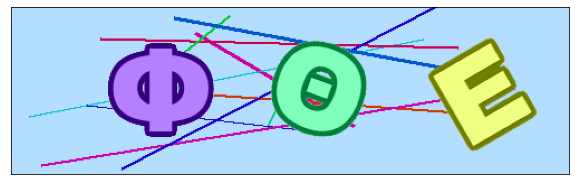

In [8]:
import matplotlib.image as mpimg

data = "./train/800.png"

fig, ax = plt.subplots(figsize=[10,10])

image = mpimg.imread(data)
imgplot = plt.imshow(image)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

### 2. Identify pixels that belong to obfuscating lines:
- Can you similarly learn a distribution on the shade/color of the obfuscating lines?

- Another technique that may help eliminate obfuscating lines is a step called erosion. Check this step out in the opencv library. This step will thin out lines so that the obfuscating lines may get very thin or even disappear. You will have to learn a good value of erosion parameter.

- Using any method (including but not limited to the above), once you have found a way to identify which pixels in an image belong to obfuscating lines, use your method(s) to eliminate obfuscating lines in images.

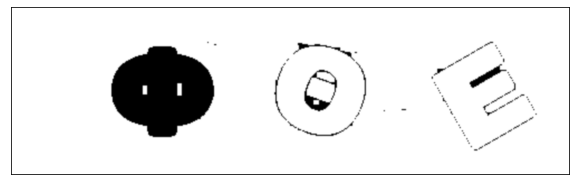

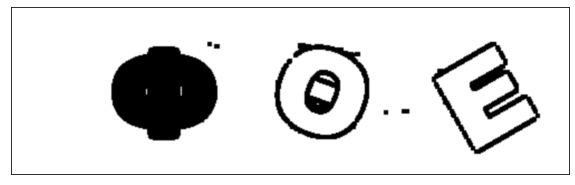

150 500


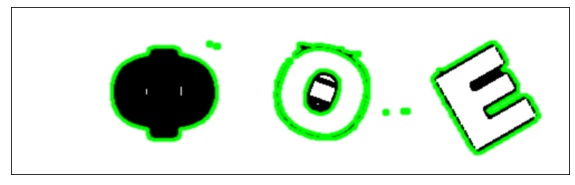

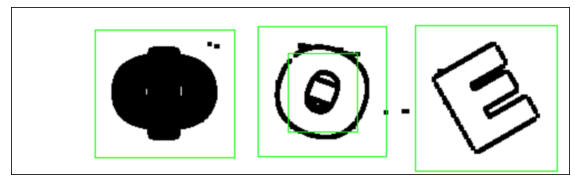

4
[]
[[0, 2]]
[]
[[0, 2]]
[[377, 32, 97, 100], [90, 36, 95, 84], [236, 33, 85, 86]]
90 36 95 84
236 33 85 86
377 32 97 100


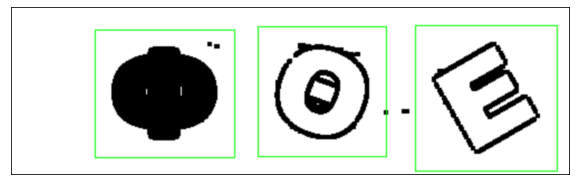

In [9]:
removed_image = remove_background(data)
alphabets = segment(removed_image)

### Learning from the training set - distribution of shade/color of the background pixels

### 3. Segment image into pieces, each containing one char:
- You may want to perform segmentation (a form of pixel clustering in images to club together adjacent pixels that are similar) to find out how many characters are present in an image. There are several segmentation techniques available (several are preimplemented) in the opencv library.

- Another technique that may help you segment the image into pieces is by looking for vertical columns of pixels that contain very few non-background pixels. This should be easy once we have learnt to identify background pixels in the previous stage. The reason this helps is that regions where there is a char, a lot of the pixels are non-background which makes it clear that a char is present.


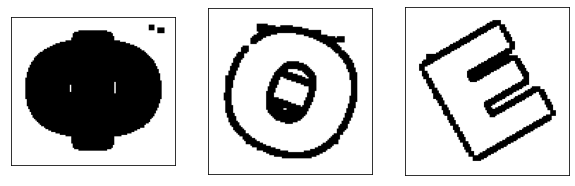

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(10, 15))
for i in range(3):
    ax = axes.flat[i]
    ax.imshow(alphabets[i])
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

The positions of i,j are identified and the letters are removed from initial consideration
Starting from the left, the end of the current letter is identified and a line is drawn removing the rest of the character: 
- Find the current starting line 
- Find up to three unique character lines 
- Calculate the next segmentation line 
- Remove all the pixels between the start line and the dividing line and save them for recognising the character 
- If we did not reach the end continue until a dividing line has been computed

If at any point the next segmentation cannot be calculated, then fail
The letters are recognised, including any i,j that were previously identified

### 4. Use ML models to identify the char in each piece:
- You may want to remove color information from the image at this stage since colors cannot help you identify which char is present in a piece (or can they?). Also, try to trim the piece so that it contains mostly the char and not too much blank space.

- The reference images may help here since the rotations which have been applied to the chars are not arbitrary but small multiples of 10 degrees.

- To exploit the above, why not create rotated versions of the reference images and see which one most closely matches the char within a given piece?

- An alternative is to instead attempt to rotate back the piece itself so that it matches one of the standard reference images.

- Try simple (linear and/or non-linear) techniques to classify every piece into one of the 24 characters. May treat this as a multiclass problem.

In [11]:
with open('./train/labels.txt') as f:
    labels = f.readlines()
    
for i in range(len(labels)):
    labels[i] = labels[i].strip()
    labels[i] = labels[i].split(',')
    

In [19]:
labels[1998]

['GAMMA', 'ZETA', 'BETA']

In [14]:
import os

train_images = []       
train_labels = []
shape = (140,140)  
train_path = './train'

index = 0

for filename in os.listdir(train_path):
    if filename.split('.')[1] == 'png':
        removed_image = remove_background(os.path.join(train_path,filename))
        alphabets = segment(removed_image)
        index += 1
        if (len(alphabets) < 3):
            continue
        for i in range(3):
            try:
                # Resize all images to a specific shape
                img = cv2.resize(alphabets[i],shape)
                train_images.append(img)
                train_labels.append(labels[index][i])
                cv2.imwrite(f"./extracted/{labels[int(filename.split('.')[0])][i]}_{filename.split('.')[0]}_{i}.png" , img)
            except Exception as e:
                print(str(e))

In [25]:
image = cv2.imread("./reference/IOTA.png")
image = Image.fromarray(image.astype('uint8'), 'RGB')
# converted to have an alpha layer
im2 = image.convert('RGBA')
# rotated image
rot = im2.rotate(30, expand=1)
# a white image same size as rotated image
fff = Image.new('RGBA', rot.size, (255,)*4)
# create a composite image using the alpha layer of rot as a mask
out = Image.composite(rot, fff, rot)
out.convert(image.mode).save(f'./reference/IOTA_{20}.png')

In [29]:
import imutils
angles = [10, -10, 20, -20, 30, -30]

letters = os.listdir(dirname)

for filename in letters:
    file, extension = filename.split(".")
    if (file == ""):
        continue
    image = cv2.imread("./reference/" + filename)
    image = Image.fromarray(image.astype('uint8'), 'RGB')
    for angle in angles:
        # converted to have an alpha layer
        im2 = image.convert('RGBA')
        # rotated image
        rot = im2.rotate(30, expand=1)
        # a white image same size as rotated image
        fff = Image.new('RGBA', rot.size, (255,)*4)
        # create a composite image using the alpha layer of rot as a mask
        out = Image.composite(rot, fff, rot)
        out.convert(image.mode).save(f"./reference/{file}_{angle}.{extension}")

In [34]:
# Processing training data
# -> appending images in a list 'train_images'
# -> appending labels in a list 'train_labels'

train_images = []       
train_labels = []

train_path = './reference'

for filename in os.listdir(train_path):
    if filename.split('.')[1] == 'png':
        img = cv2.imread(os.path.join(train_path,filename))
        # Spliting file names and storing the labels for image in list
        if '_' in filename:
            train_labels.append(filename.split('_')[0])
        else:
            train_labels.append(filename.split('.')[0])
        
        # Resize all images to a specific shape
        img = cv2.resize(img,shape)
        
        train_images.append(img)
        
train_path = './extracted'

for filename in os.listdir(train_path):
    if filename.split('.')[1] == 'png':
        img = cv2.imread(os.path.join(train_path,filename))
        # Spliting file names and storing the labels for image in list
        train_labels.append(filename.split('_')[0])
        
        train_images.append(img)
        
print(train_labels)

['EPSILON', 'IOTA', 'OMEGA', 'BETA', 'XI', 'MU', 'RHO', 'GAMMA', 'DELTA', 'ETA', 'ETA', 'IOTA', 'CHI', 'KAPPA', 'ZETA', 'XI', 'UPSILON', 'PSI', 'LAMDA', 'THETA', 'ZETA', 'NU', 'CHI', 'KAPPA', 'MU', 'IOTA', 'THETA', 'ETA', 'PHI', 'DELTA', 'ETA', 'GAMMA', 'GAMMA', 'TAU', 'XI', 'MU', 'LAMDA', 'OMEGA', 'PI', 'BETA', 'IOTA', 'PSI', 'SIGMA', 'LAMDA', 'ALPHA', 'UPSILON', 'SIGMA', 'EPSILON', 'UPSILON', 'TAU', 'ALPHA', 'PI', 'OMEGA', 'ZETA', 'OMICRON', 'PHI', 'OMEGA', 'PHI', 'PHI', 'TAU', 'DELTA', 'ZETA', 'KAPPA', 'OMICRON', 'PI', 'SIGMA', 'EPSILON', 'NU', 'CHI', 'RHO', 'THETA', 'UPSILON', 'PSI', 'ALPHA', 'SIGMA', 'BETA', 'RHO', 'MU', 'TAU', 'UPSILON', 'CHI', 'NU', 'DELTA', 'UPSILON', 'RHO', 'OMICRON', 'ALPHA', 'LAMDA', 'SIGMA', 'ALPHA', 'BETA', 'RHO', 'MU', 'PHI', 'DELTA', 'PHI', 'OMICRON', 'KAPPA', 'OMEGA', 'OMICRON', 'PI', 'PI', 'OMICRON', 'ETA', 'OMEGA', 'KAPPA', 'ZETA', 'PHI', 'OMICRON', 'DELTA', 'MU', 'RHO', 'KAPPA', 'BETA', 'SIGMA', 'ALPHA', 'PSI', 'ALPHA', 'LAMDA', 'RHO', 'CHI', 'NU', '

In [36]:
set(train_labels)

{'ALPHA',
 'BETA',
 'CHI',
 'DELTA',
 'EPSILON',
 'ETA',
 'GAMMA',
 'IOTA',
 'KAPPA',
 'LAMDA',
 'MU',
 'NU',
 'OMEGA',
 'OMICRON',
 'PHI',
 'PI',
 'PSI',
 'RHO',
 'SIGMA',
 'TAU',
 'THETA',
 'UPSILON',
 'XI',
 'ZETA'}

In [32]:
# Converting train_images to array
train_images = np.array(train_images)

# Converting labels into One Hot encoded sparse matrix
print(pd.get_dummies(train_labels))

train_labels = pd.get_dummies(train_labels).values

      ALPHA  BETA  CHI  DELTA  EPSILON  ETA  GAMMA  IOTA  KAPPA  LAMDA  ...  \
0         0     0    0      0        1    0      0     0      0      0  ...   
1         0     0    0      0        0    0      0     1      0      0  ...   
2         0     0    0      0        0    0      0     0      0      0  ...   
3         0     1    0      0        0    0      0     0      0      0  ...   
4         0     0    0      0        0    0      0     0      0      0  ...   
...     ...   ...  ...    ...      ...  ...    ...   ...    ...    ...  ...   
6055      0     0    0      0        0    0      0     0      0      0  ...   
6056      0     0    0      0        0    0      0     0      0      0  ...   
6057      0     0    0      0        0    0      1     0      0      0  ...   
6058      0     0    0      0        0    0      1     0      0      0  ...   
6059      0     0    0      0        0    0      0     0      0      0  ...   

      PHI  PI  PSI  RHO  SIGMA  TAU  THETA  UPSILON

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [33]:
len(train_labels)

6060

In [39]:
# Converting labels into One Hot encoded sparse matrix
# print(pd.get_dummies(train_labels))
train_labels_1 = pd.get_dummies(train_labels).values
print(train_labels_1)

# Converting train_images to array
train_images = np.array(train_images)

# Splitting Training data into train and validation dataset
x_train,x_val,y_train,y_val = train_test_split(train_images,train_labels_1,random_state=1)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [38]:
from keras.utils import to_categorical
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout
from keras.models import Sequential
import keras.optimizers as optimizers

from sklearn.model_selection import train_test_split

[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
ETA


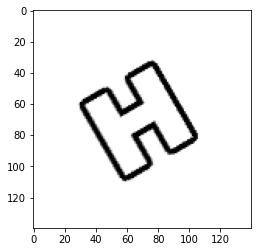

In [42]:
# Visualizing Training data
print(train_labels_1[9])
print(train_labels[9])
plt.imshow(train_images[9])

In [43]:
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(140, 140, 3)))
model1.add(MaxPool2D((2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPool2D((2, 2)))

model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPool2D((2, 2)))

model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPool2D((2, 2)))

model1.add(Flatten())

model1.add(Dense(512, activation='relu'))

model1.add(Dense(24, activation='sigmoid'))

2022-11-28 13:54:56.172808: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [45]:
# Model Summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 138, 138, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 69, 69, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 67, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 33, 33, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0

In [46]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Model1.h5", save_best_only=True)

In [48]:
model1.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

/Users/shreyasi/opt/anaconda3/envs/CS771/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [49]:
# Training the model
history = model1.fit(x_train,y_train,epochs=50,batch_size=50,validation_data=(x_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
91/91 [==============================] - 58s 623ms/step - loss: 6.5926 - acc: 0.4229 - val_loss: 0.8299 - val_acc: 0.7954
Epoch 2/50
91/91 [==============================] - 56s 612ms/step - loss: 0.4990 - acc: 0.8788 - val_loss: 0.3728 - val_acc: 0.9155
Epoch 3/50
91/91 [==============================] - 56s 612ms/step - loss: 0.2243 - acc: 0.9446 - val_loss: 0.3969 - val_acc: 0.9168
Epoch 4/50
91/91 [==============================] - 56s 611ms/step - loss: 0.1043 - acc: 0.9745 - val_loss: 0.3104 - val_acc: 0.9399
Epoch 5/50
91/91 [==============================] - 55s 609ms/step - loss: 0.0641 - acc: 0.9872 - val_loss: 0.5399 - val_acc: 0.9089
Epoch 6/50
91/91 [==============================] - 58s 641ms/step - loss: 0.0534 - acc: 0.9903 - val_loss: 0.3276 - val_acc: 0.9432
Epoch 7/50
91/91 [==============================] - 57s 623ms/step - loss: 0.0543 - acc: 0.9908 - val_loss: 0.2887 - val_acc: 0.9492
Epoch 8/50
91/91 [==============================] - 57s 627ms/step - 

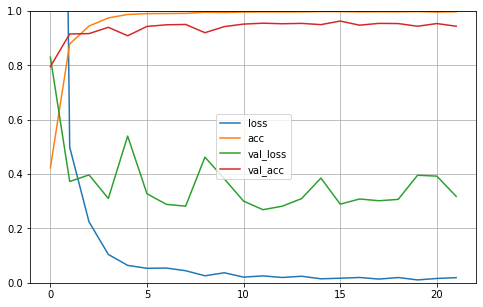

In [50]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [52]:
# Evaluating model on validation data
evaluate = model1.evaluate(x_train,y_train)
print(evaluate)

143/143 [==============================] - 18s 123ms/step - loss: 0.0078 - acc: 0.9982
[0.007812847383320332, 0.9982398152351379]


In [54]:
# Evaluating model on validation data
evaluate = model1.evaluate(x_val,y_val)
print(evaluate)

48/48 [==============================] - 6s 123ms/step - loss: 0.2689 - acc: 0.9551
[0.26893001794815063, 0.9551154971122742]


(298, 314, 3)


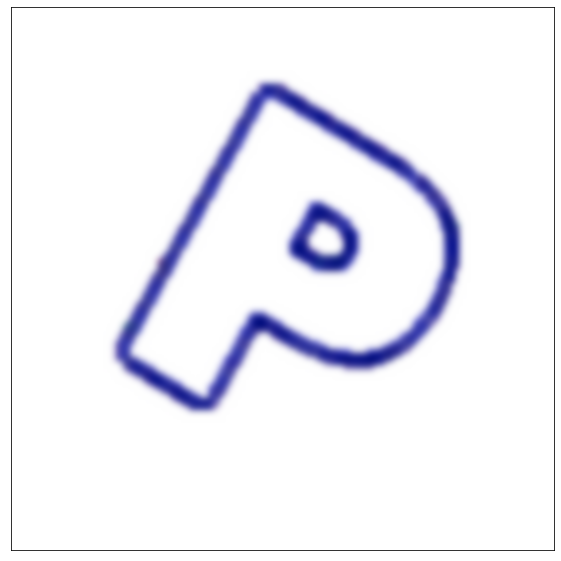

(1, 140, 140, 3)


In [55]:
img = cv2.imread("./test.png")
print(img.shape)
img = cv2.resize(img,(140, 140))
showimage(img)
img = np.reshape(img, (1, 140, 140, 3))
print(img.shape)

In [56]:
predict = model1.predict(np.array(img))

1/1 [==============================] - 0s 194ms/step


In [57]:
predict

array([[0.8834685 , 0.5965937 , 0.32522464, 0.2409214 , 0.04295617,
        0.5013491 , 0.41464102, 0.46047473, 0.84955776, 0.45715412,
        0.91774774, 0.3725271 , 0.2825589 , 0.61831343, 0.5577111 ,
        0.26976585, 0.4716222 , 0.8268931 , 0.23056923, 0.07055853,
        0.1368812 , 0.6976451 , 0.25764978, 0.28678364]], dtype=float32)

In [58]:
np.argmax(predict)

10

(140, 140, 3)


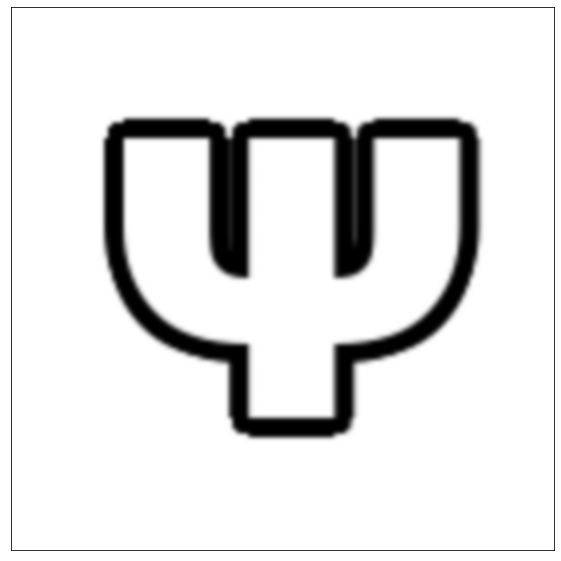

(1, 140, 140, 3)


In [59]:
img = cv2.imread("./reference/PSI.png")
print(img.shape)
img = cv2.resize(img,(140, 140))
showimage(img)
img = np.reshape(img, (1, 140, 140, 3))
print(img.shape)

In [60]:
predict = model1.predict(np.array(img))
np.argmax(predict)

1/1 [==============================] - 0s 24ms/step


16

In [61]:
model = tf.keras.models.load_model("Model1.h5") # add model :)

In [62]:
# Evaluating model on validation data
evaluate = model.evaluate(x_train,y_train)
print(evaluate)

143/143 [==============================] - 18s 123ms/step - loss: 0.0078 - acc: 0.9982
[0.007812847383320332, 0.9982398152351379]


In [63]:
# Evaluating model on validation data
evaluate = model.evaluate(x_val,y_val)
print(evaluate)

48/48 [==============================] - 6s 123ms/step - loss: 0.2689 - acc: 0.9551
[0.26893001794815063, 0.9551154971122742]


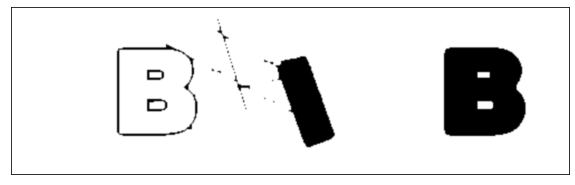

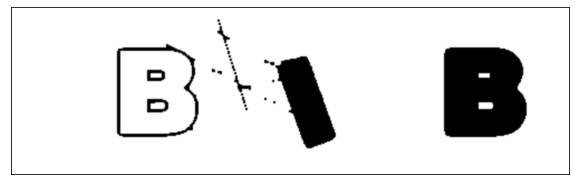

150 500


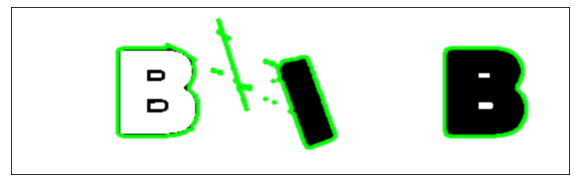

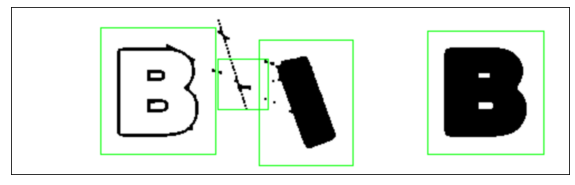

4
[]
[]
[]
[]
[[95, 34, 73, 83], [388, 37, 74, 80], [237, 45, 54, 82], [200, 62, 15, 15]]
95 34 73 83
237 45 54 82
388 37 74 80


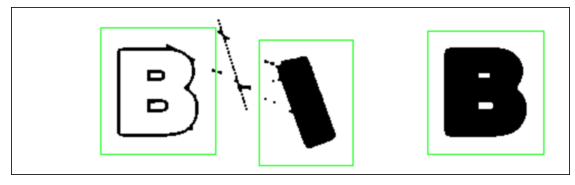

1/1 [==============================] - 0s 26ms/step
BETA,IOTA,BETA,


In [70]:
names = ['ALPHA','BETA','CHI','DELTA','EPSILON','ETA','GAMMA','IOTA','KAPPA',
            'LAMDA','MU','NU','OMEGA','OMICRON','PHI','PI','PSI','RHO','SIGMA','TAU',
            'THETA','UPSILON','XI','ZETA']
removed_image = remove_background("1.png")
alphabets = segment(removed_image)
result = ""
for letter in alphabets:
    try:
        letter = cv2.resize(letter,(140, 140))
        letter = np.reshape(letter, (1, 140, 140, 3))
        predict = model.predict(np.array(letter))
        result = result + str(names[np.argmax(predict)]) + ','
    except Exception as e:
        result = result + "_" + ","
        
print(result)